In [55]:
# 541 samples
# NEW new normalizations
# NOT normalizing the inputs
# normalizing outputs
# no more train_test_split
# trialing epochs
#trialing validations
# trial various activation functions

# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import lalsimulation as lal
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
import keras
import keras_metrics as km
import keras
from keras import metrics


gpu_num = 1

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        tf.config.experimental.set_visible_devices(gpus[gpu_num], 'GPU')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2023-10-31 13:28:24.339424: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-31 13:28:24.378749: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 13:28:24.995610: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/braun2/anaconda3/envs/tf/lib/python3.8/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable local

In [2]:
gamma0_real = np.loadtxt("test_gamma_0.dat", dtype=float)
gamma1_real = np.loadtxt("test_gamma_1.dat", dtype=float)
gamma2_real = np.loadtxt("test_gamma_2.dat", dtype=float)
l1_real = np.loadtxt('test_lambda_1.dat', dtype=float)
l2_real = np.loadtxt('test_lambda_2.dat', dtype=float)
logp1_cgs = np.loadtxt("test_logp1_cgs.dat", dtype=float)
logp2_cgs = np.loadtxt("test_logp2_cgs.dat", dtype=float)
m1_real = np.loadtxt("test_mass_1.dat", dtype=float)
m2_real = np.loadtxt("test_mass_2.dat", dtype=float)

In [3]:
len(m2_real)

541

In [4]:
m1_dat = m1_real
m2_dat = m2_real
l1_dat = l1_real
l2_dat = l2_real

In [5]:
.8 * 541

432.8

# Functions

In [6]:
#formatting array & processing outputs

def format_output(data):
    gamma0 = data.pop('gamma0')
    gamma0 = np.array(gamma0)
    gamma1 = data.pop('gamma1')
    gamma1 = np.array(gamma1)
    gamma2 = data.pop('gamma2')
    gamma2 = np.array(gamma2)
    logp1_si = data.pop('logp1_si')
    logp1_si = np.array(logp1_si)
    logp2_si = data.pop('logp2_si')
    logp2_si = np.array(logp2_si)
    return gamma0, gamma1, gamma2, logp1_si, logp2_si



In [7]:
#return inputs back to original values in order to plot EOS

# log(p1) & p2 ∈ [33, 37], in cgs
# Γ0, Γ1, Γ2 ∈ [1.0, 5.0]


# unnorm function 1
def unnorm(predictionsarray):
    
    for i in range (len(predictionsarray)):
        new_gamma0_array = predictionsarray[0] * (5 - 1) + 1
        new_gamma1_array = predictionsarray[1] * (5 - 1) + 1
        new_gamma2_array = predictionsarray[2] * (5 - 1) + 1
        
        #cgs
        cgs_logp1 = predictionsarray[3]
        cgs_logp2 = predictionsarray[4]
        
        #normalize in si
        si_logp1_unnorm = cgs_logp1 * ((37-1) - (33-1)) + (33-1) +1
        si_logp2_unnorm = cgs_logp2 * ((37-1) - (33-1)) + (33-1) +1
        
        
        #convert back to si
        #new_logp1_array = cgs_logp1_unnorm - 1
        #new_logp2_array = cgs_logp2_unnorm - 1
    
    new_array = np.concatenate((new_gamma0_array, new_gamma1_array, new_gamma2_array, si_logp1_unnorm, si_logp2_unnorm), axis=1)

    return new_array



# unnorm function 2
def minmaxunnorm(predictionsarray):

    for i in range (len(predictionsarray)):
        
        gam0 = predictionsarray[0]
        gam1 = predictionsarray[1]
        gam2 = predictionsarray[2]
        
        gam0max = np.max(predictionsarray[0])
        gam0min = np.min(predictionsarray[0])
        
        gam1max = np.max(predictionsarray[1])
        gam1min = np.min(predictionsarray[1])
        
        gam2max = np.max(predictionsarray[2])
        gam2min = np.min(predictionsarray[2])
        
        new_gamma0_array = (5 - 1)*((gam0 - gam0min)/(gam0max-gam0min)) + 1
        new_gamma1_array = (5 - 1)*((gam1 - gam1min)/(gam1max-gam1min)) + 1
        new_gamma2_array = (5 - 1)*((gam2 - gam2min)/(gam2max-gam2min)) + 1

        
        
        si_logp1 = predictionsarray[3]
        si_logp2 = predictionsarray[4]
        
        logp1max = np.max(si_logp1)
        logp1min = np.min(si_logp1)
        
        logp2max = np.max(si_logp2)
        logp2min = np.min(si_logp2)
        
        #minmax normalization
        
        #range [a,b]
        #measured min: min
        #measured max: max
        #array = x
        
        # (b - a) ((x - min)/(max-min)) + a
        # [32, 36]
        
        new_logp1_array = (36 - 32)*((si_logp1 - logp1min)/(logp1max-logp1min)) + 32
        new_logp2_array = (36 - 32)*((si_logp2 - logp2min)/(logp2max-logp2min)) + 32
    
    new_array = np.concatenate((new_gamma0_array, new_gamma1_array, new_gamma2_array, new_logp1_array, new_logp2_array), axis=1)

    return new_array


# MLA

In [8]:
#normalizing to be between 0 and 1!


# log(p1) & p2 ∈ [33, 37], in cgs
# Γ0, Γ1, Γ2 ∈ [1.0, 5.0]

#normalizing into si (using bounds 32 and 36)

logp1_s_norm = ((logp1_cgs - 1) - (33-1))/((37-1) - (33-1))
logp2_s_norm = ((logp2_cgs - 1) - (33-1))/((37-1) - (33-1))

logp1_si = logp1_s_norm
logp2_si = logp2_s_norm


sd_gamma0 = (gamma0_real - 1)/(5 - 1)
sd_gamma1 = (gamma1_real - 1)/(5 - 1)
sd_gamma2 = (gamma2_real - 1)/(5 - 1)


un-normalized outputs

1.2794975575618972
4.994009023889495


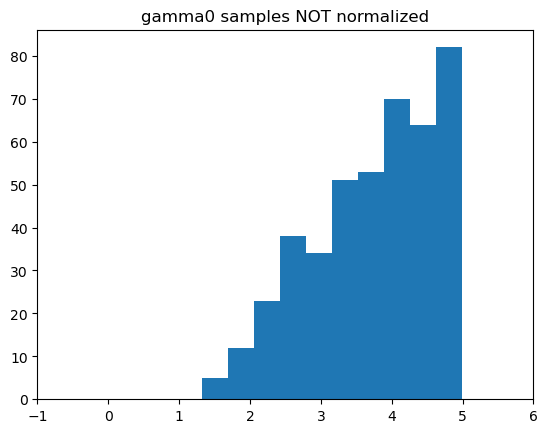

1.0004706315315508
4.999271487105766


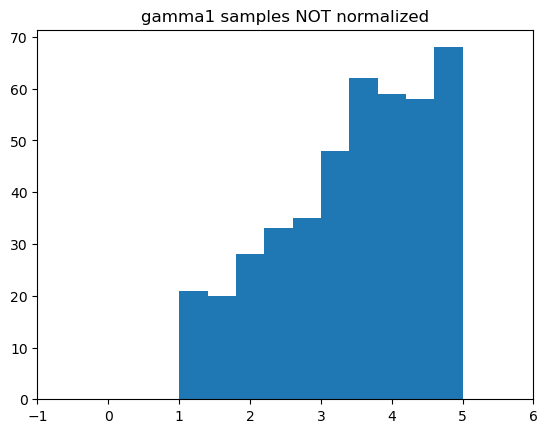

1.000231270745974
2.957224084475217


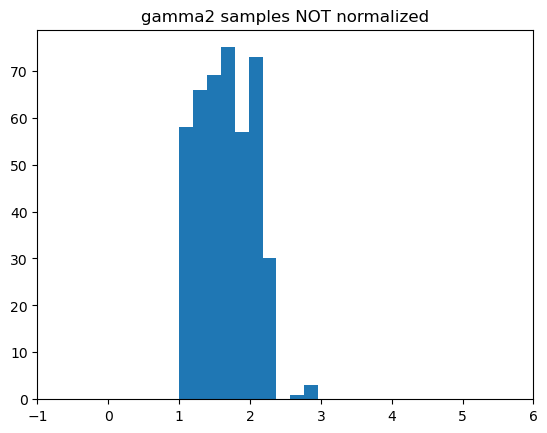

0.0012066484461676907
0.960923412585478


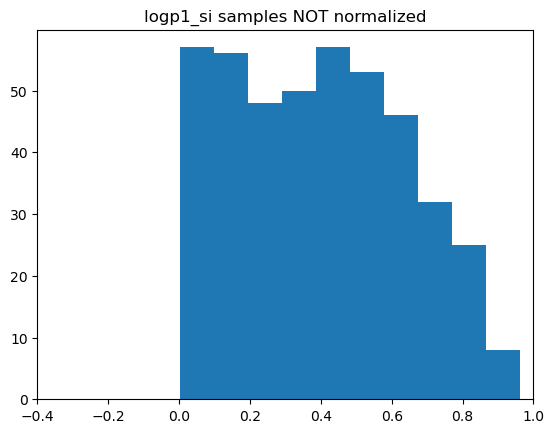

0.056537653575921
0.9995282578078619


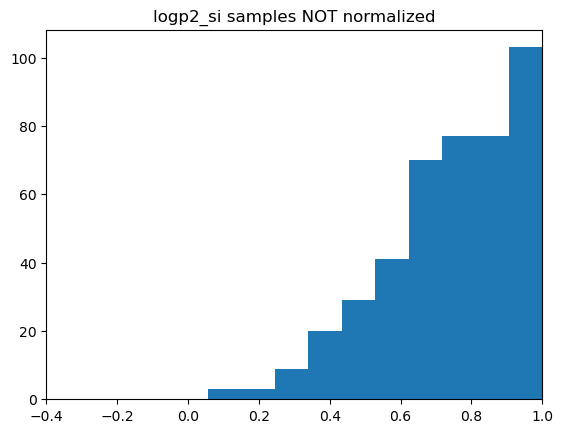

In [9]:
plt.hist(gamma0_real[0:432])
plt.title("gamma0 samples NOT normalized")
print(np.min(gamma0_real))
print(np.max(gamma0_real))
plt.xlim(-1, 6)
plt.show()

plt.hist(gamma1_real[0:432])
plt.title("gamma1 samples NOT normalized")
print(np.min(gamma1_real))
print(np.max(gamma1_real))
plt.xlim(-1, 6)
plt.show()

plt.hist(gamma2_real[0:432])
plt.title("gamma2 samples NOT normalized")
print(np.min(gamma2_real))
print(np.max(gamma2_real))
plt.xlim(-1, 6)
plt.show()

plt.hist(logp1_s_norm[0:432])
plt.title("logp1_si samples NOT normalized")
print(np.min(logp1_si))
print(np.max(logp1_si))
plt.xlim(-.4, 1)
plt.show()

plt.hist(logp2_s_norm[0:432])
plt.title("logp2_si samples NOT normalized")
print(np.min(logp2_si))
print(np.max(logp2_si))
plt.xlim(-.4, 1)
plt.show()

normalized outputs

0.0698743893904743
0.9985022559723737


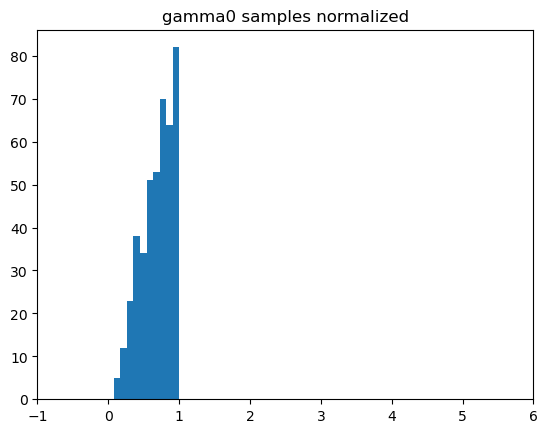

0.00011765788288770063
0.9998178717764414


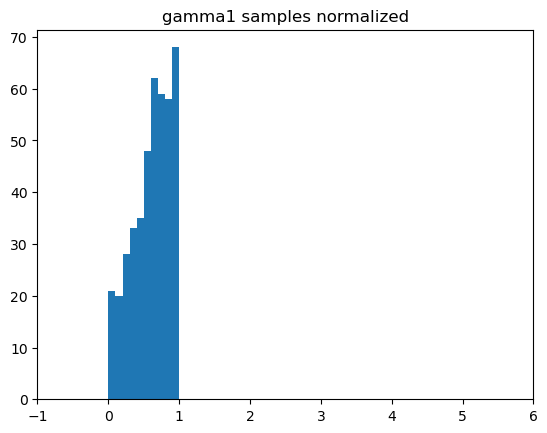

5.781768649348873e-05
0.4893060211188043


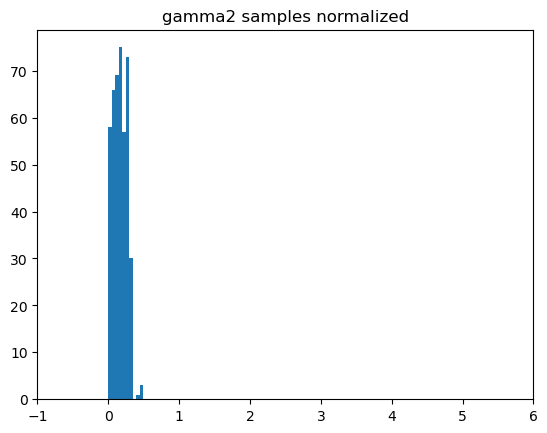

0.0012066484461676907
0.960923412585478


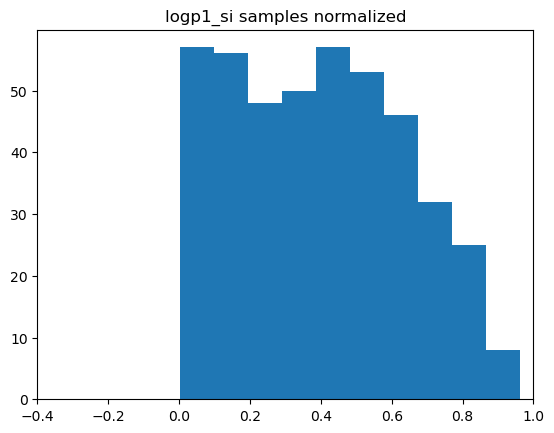

0.056537653575921
0.9995282578078619


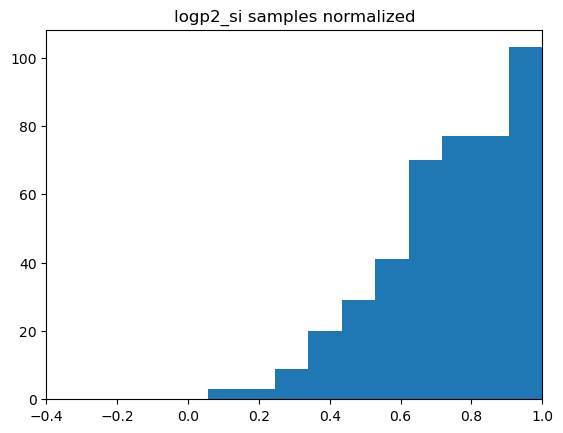

In [10]:
plt.hist(sd_gamma0[0:432])
plt.title("gamma0 samples normalized")
print(np.min(sd_gamma0))
print(np.max(sd_gamma0))
plt.xlim(-1, 6)
plt.show()

plt.hist(sd_gamma1[0:432])
plt.title("gamma1 samples normalized")
print(np.min(sd_gamma1))
print(np.max(sd_gamma1))
plt.xlim(-1, 6)
plt.show()

plt.hist(sd_gamma2[0:432])
plt.title("gamma2 samples normalized")
print(np.min(sd_gamma2))
print(np.max(sd_gamma2))
plt.xlim(-1, 6)
plt.show()

plt.hist(logp1_si[0:432])
plt.title("logp1_si samples normalized")
print(np.min(logp1_si))
print(np.max(logp1_si))
plt.xlim(-.4, 1)
plt.show()

plt.hist(logp2_si[0:432])
plt.title("logp2_si samples normalized")
print(np.min(logp2_si))
print(np.max(logp2_si))
plt.xlim(-.4, 1)
plt.show()

In [11]:
#create an empty array 8 x length(m1_dat]) for vals
array_size =  np.array([[0] * 9 ] * len(sd_gamma0))
array_size = array_size.astype('float64')
combined_array = np.zeros_like(array_size)
print(combined_array.dtype)
print(combined_array.shape)

float64
(541, 9)


In [12]:
#reformat data files into this new array
for i in range(0,len(m1_dat)-1):
    combined_array[i][0] = m1_dat[i]
    combined_array[i][1] = m2_dat[i]
    combined_array[i][2] = l1_dat[i]
    combined_array[i][3] = l2_dat[i]
    combined_array[i][4] = sd_gamma0[i]
    combined_array[i][5] = sd_gamma1[i]
    combined_array[i][6] = sd_gamma2[i]
    combined_array[i][7] = logp1_si[i]
    combined_array[i][8] = logp2_si[i]
    

In [13]:
data = pd.DataFrame(combined_array)
data.columns = ['m1','m2', 'l1', 'l2','gamma0', 'gamma1', 'gamma2', 'logp1_si', 'logp2_si']
print(data)

           m1        m2            l1            l2    gamma0    gamma1  \
0    0.917844  0.664838  10309.423198  45454.839034  0.648856  0.745487   
1    2.535693  2.119748     21.983584     93.433939  0.630087  0.988135   
2    0.876440  0.544662   6285.673678  66908.231217  0.479282  0.037464   
3    4.197769  2.922266      2.104015     56.536123  0.997567  0.735291   
4    2.489261  1.330280     98.981223   3012.682289  0.875637  0.550842   
..        ...       ...           ...           ...       ...       ...   
536  2.170350  1.992358    135.542559    230.419913  0.716868  0.919516   
537  0.960622  0.662081     26.347301    391.555249  0.153341  0.610729   
538  0.974471  0.579292   4764.888085  54822.247158  0.497121  0.784112   
539  1.733165  1.563308    691.756899   1181.733758  0.816467  0.800277   
540  0.000000  0.000000      0.000000      0.000000  0.000000  0.000000   

       gamma2  logp1_si  logp2_si  
0    0.148472  0.413552  0.498441  
1    0.068198  0.599191  0.

In [14]:
# 541 total samples: 80% = 432, 20% = 108.2
# for train and test ONLY:
# we want the first 432 samples to = train
# we want the last 109 samples to = test
# split row-wise, not collumn-wise

# splitting dataframe by row index
train = data.iloc[:int(len(m2_real)*.8),:]
test = data.iloc[int(len(m2_real)*.8):,:]
print("Shape of new dataframes - {} , {}".format(train.shape, test.shape))

train_stats = train.describe()

train_stats.pop('gamma0')
train_stats.pop('gamma1')
train_stats.pop('gamma2')
train_stats.pop('logp1_si')
train_stats.pop('logp2_si')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)


Shape of new dataframes - (432, 9) , (109, 9)


In [15]:
#split data into train and test

data = data.sample(frac=1).reset_index(drop=True)

train, test = train_test_split(data, test_size=0.2)

print(train)

train_stats = train.describe()

#get gamma as the outputs and format them as np arrays.

train_stats.pop('gamma0')
train_stats.pop('gamma1')
train_stats.pop('gamma2')
train_stats.pop('logp1_si')
train_stats.pop('logp2_si')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

           m1        m2            l1            l2    gamma0    gamma1  \
276  1.500931  1.030595   1952.766771  10942.350125  0.955240  0.972224   
254  0.917844  0.664838  10309.423198  45454.839034  0.648856  0.745487   
496  1.251291  1.137481   2613.997866   4184.081603  0.692655  0.250618   
230  1.460761  1.268300     14.450392     54.967263  0.078939  0.585768   
73   1.810255  1.021187    606.723445  10387.225945  0.934719  0.711225   
..        ...       ...           ...           ...       ...       ...   
290  1.567292  0.890650     83.012753   1843.046792  0.236243  0.908686   
105  1.618673  0.896770   1090.601808  17109.793675  0.821939  0.902611   
45   2.331039  1.663094      6.912888    116.571771  0.367342  0.836356   
325  1.072632  0.766650   7989.882786  35283.772660  0.862186  0.905388   
172  1.746861  0.802563     41.320488   6006.395475  0.410083  0.753879   

       gamma2  logp1_si  logp2_si  
276  0.294072  0.244086  0.610426  
254  0.148472  0.413552  0.

In [16]:
norm_train_X = train
norm_test_X = test

In [20]:
len(train.columns)

4

In [17]:
input_layer = Input(shape=(len(train .columns),))

layeract = 'tanh'
outputact = 'sigmoid'

first_dense = Dense(units='128', activation=layeract)(input_layer)
second_dense = Dense(units='128', activation=layeract)(first_dense)
third_dense = Dense(units='128', activation=layeract)(second_dense)
fourth_dense = Dense(units='128', activation=layeract)(third_dense)
fifth_dense = Dense(units='128', activation=layeract)(fourth_dense)
sixth_dense = Dense(units='128', activation=layeract)(fifth_dense)
seventh_dense = Dense(units='128', activation=layeract)(sixth_dense)
eight_dense = Dense(units='128', activation=layeract)(seventh_dense)
ninth_dense = Dense(units='128', activation=layeract)(eight_dense)
    
tenth_dense = Dense(units='128', activation=layeract)(ninth_dense)
eleventh_dense = Dense(units='128', activation=layeract)(tenth_dense)
twelth_dense = Dense(units='128', activation=layeract)(eleventh_dense)
thirteenth_dense = Dense(units='128', activation=layeract)(twelth_dense)
fourteenth_dense = Dense(units='128', activation=layeract)(thirteenth_dense)
fifteenth_dense = Dense(units='128', activation=layeract)(fourteenth_dense)
sixteenth_dense = Dense(units='128', activation=layeract)(fifteenth_dense)
seventeenth_dense = Dense(units='128', activation=layeract)(sixteenth_dense)
eighteenth_dense = Dense(units='128', activation=layeract)(seventeenth_dense)
nineteenth_dense = Dense(units='128', activation=layeract)(eighteenth_dense)
    
twentieth_dense = Dense(units='128', activation=layeract)(nineteenth_dense)
tf_dense = Dense(units='128', activation=layeract)(twentieth_dense)
ts_dense = Dense(units='128', activation=layeract)(tf_dense)
tt_dense = Dense(units='128', activation=layeract)(ts_dense)
tfo_dense = Dense(units='128', activation=layeract)(tt_dense)
tfi_dense = Dense(units='128', activation=layeract)(tfo_dense)
ts_dense = Dense(units='128', activation=layeract)(tfi_dense)
tse_dense = Dense(units='128', activation=layeract)(ts_dense)
te_dense = Dense(units='128', activation=layeract)(tse_dense)
tn_dense = Dense(units='128', activation=layeract)(te_dense)


gamma0_output = Dense(units='1', activation=outputact, name='gamma0_output')(tn_dense)
thf_dense = Dense(units='64', activation=layeract)(tn_dense)

ths_dense = Dense(units='128', activation=layeract)(thf_dense)
tht_dense = Dense(units='128', activation=layeract)(ths_dense)
thfo_dense = Dense(units='128', activation=layeract)(tht_dense)
thfi_dense = Dense(units='128', activation=layeract)(thfo_dense)
ths_dense = Dense(units='128', activation=layeract)(thfi_dense)
thse_dense = Dense(units='128', activation=layeract)(ths_dense)
the_dense = Dense(units='128', activation=layeract)(thse_dense)
thn_dense = Dense(units='128', activation=layeract)(the_dense)

gamma1_output = Dense(units='1', activation=outputact, name='gamma1_output')(thn_dense)
fo_dense = Dense(units='32',activation=layeract)(thn_dense)

fof_dense = Dense(units='128', activation=layeract)(fo_dense)
fos_dense = Dense(units='128', activation=layeract)(fof_dense)
fot_dense = Dense(units='128', activation=layeract)(fos_dense)
fofo_dense = Dense(units='128', activation=layeract)(fot_dense)
fofi_dense = Dense(units='128', activation=layeract)(fofo_dense)

gamma2_output = Dense(units='1', activation=outputact, name='gamma2_output')(fofi_dense)
fos_dense = Dense(units='16',activation=layeract)(fofi_dense)

fose_dense = Dense(units='128', activation=layeract)(fos_dense)
foe_dense = Dense(units='128', activation=layeract)(fose_dense)
fon_dense = Dense(units='128', activation=layeract)(foe_dense)
fif_dense = Dense(units='128', activation=layeract)(fon_dense)

logp1_si_output = Dense(units='1', activation=outputact, name='logp1_si_output')(fon_dense)

fiff_dense = Dense(units='128', activation=layeract)(fon_dense)
fifs_dense = Dense(units='128', activation=layeract)(fiff_dense)
fift_dense = Dense(units='128', activation=layeract)(fifs_dense)
fiff_dense = Dense(units='128', activation=layeract)(fift_dense)
fiffi_dense = Dense(units='128', activation=layeract)(fiff_dense)
fifs_dense = Dense(units='128', activation=layeract)(fiffi_dense)

logp2_si_output = Dense(units='1', activation=outputact, name='logp2_si_output')(fifs_dense)


model = Model(inputs=input_layer, outputs=[gamma0_output, gamma1_output, gamma2_output, logp1_si_output, logp2_si_output])

print(model.summary())

2023-10-31 13:28:54.107030: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45592 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2023-10-31 13:28:54.107492: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46258 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  640       ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  16512     ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 128)                  16512     ['dense_1[0][0]']             
                                                                                              

 dense_39 (Dense)            (None, 128)                  4224      ['dense_38[0][0]']            
                                                                                                  
 dense_40 (Dense)            (None, 128)                  16512     ['dense_39[0][0]']            
                                                                                                  
 dense_41 (Dense)            (None, 128)                  16512     ['dense_40[0][0]']            
                                                                                                  
 dense_42 (Dense)            (None, 128)                  16512     ['dense_41[0][0]']            
                                                                                                  
 dense_43 (Dense)            (None, 128)                  16512     ['dense_42[0][0]']            
                                                                                                  
 dense_44 

In [52]:
#plot_model(model, to_file='DynamicPolytropeMLA.png', show_shapes=True, show_layer_names=True)

In [53]:
#specify the optimizer as stochastic gradient descent and will mention the learning rate as 0.001
#compile the model with loss functions for both outputs
from keras import metrics

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss={'gamma0_output': 'mse', 'gamma1_output': 'mse', 'gamma2_output': 'mse', 'logp1_si_output': 'mse', 'logp2_si_output': 'mse'},
              metrics={
                       'gamma0_output': tf.keras.metrics.MeanSquaredError() ,
                       'gamma1_output': tf.keras.metrics.MeanSquaredError(),
                       'gamma2_output': tf.keras.metrics.MeanSquaredError() ,
                       'logp1_si_output': tf.keras.metrics.MeanSquaredError(),
                       'logp2_si_output': tf.keras.metrics.MeanSquaredError()
                      })

endmetric = "mean_squared_error"

In [21]:
#train the model for a number of epochs

numepochs = 500
    
history = model.fit(norm_train_X.to_numpy(), train_Y,
                    epochs=numepochs, batch_size=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=200,mode='auto')])


Epoch 1/100


2023-10-31 12:44:12.374819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-31 12:44:12.625096: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x14e2249b4e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-31 12:44:12.625118: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-31 12:44:12.625122: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-31 12:44:12.629231: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-31 12:44:12.772393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-31 12:44:12.85360

35/35 [==============================] - 11s 23ms/step - loss: 0.2499 - gamma0_output_loss: 0.0501 - gamma1_output_loss: 0.0781 - gamma2_output_loss: 0.0161 - logp1_si_output_loss: 0.0659 - logp2_si_output_loss: 0.0397 - gamma0_output_mean_squared_error: 0.0501 - gamma1_output_mean_squared_error: 0.0781 - gamma2_output_mean_squared_error: 0.0161 - logp1_si_output_mean_squared_error: 0.0659 - logp2_si_output_mean_squared_error: 0.0397 - val_loss: 0.2487 - val_gamma0_output_loss: 0.0627 - val_gamma1_output_loss: 0.0815 - val_gamma2_output_loss: 0.0100 - val_logp1_si_output_loss: 0.0601 - val_logp2_si_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0627 - val_gamma1_output_mean_squared_error: 0.0815 - val_gamma2_output_mean_squared_error: 0.0100 - val_logp1_si_output_mean_squared_error: 0.0601 - val_logp2_si_output_mean_squared_error: 0.0343
Epoch 2/100
35/35 [==============================] - 0s 9ms/step - loss: 0.2374 - gamma0_output_loss: 0.0503 - gamma1_output_loss: 0.07

35/35 [==============================] - 0s 9ms/step - loss: 0.2313 - gamma0_output_loss: 0.0491 - gamma1_output_loss: 0.0731 - gamma2_output_loss: 0.0093 - logp1_si_output_loss: 0.0646 - logp2_si_output_loss: 0.0353 - gamma0_output_mean_squared_error: 0.0491 - gamma1_output_mean_squared_error: 0.0731 - gamma2_output_mean_squared_error: 0.0093 - logp1_si_output_mean_squared_error: 0.0646 - logp2_si_output_mean_squared_error: 0.0353 - val_loss: 0.2394 - val_gamma0_output_loss: 0.0571 - val_gamma1_output_loss: 0.0748 - val_gamma2_output_loss: 0.0108 - val_logp1_si_output_loss: 0.0632 - val_logp2_si_output_loss: 0.0336 - val_gamma0_output_mean_squared_error: 0.0571 - val_gamma1_output_mean_squared_error: 0.0748 - val_gamma2_output_mean_squared_error: 0.0108 - val_logp1_si_output_mean_squared_error: 0.0632 - val_logp2_si_output_mean_squared_error: 0.0336
Epoch 20/100
35/35 [==============================] - 0s 9ms/step - loss: 0.2298 - gamma0_output_loss: 0.0493 - gamma1_output_loss: 0.072

35/35 [==============================] - 0s 9ms/step - loss: 0.2270 - gamma0_output_loss: 0.0486 - gamma1_output_loss: 0.0719 - gamma2_output_loss: 0.0090 - logp1_si_output_loss: 0.0629 - logp2_si_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0486 - gamma1_output_mean_squared_error: 0.0719 - gamma2_output_mean_squared_error: 0.0090 - logp1_si_output_mean_squared_error: 0.0629 - logp2_si_output_mean_squared_error: 0.0347 - val_loss: 0.2344 - val_gamma0_output_loss: 0.0555 - val_gamma1_output_loss: 0.0737 - val_gamma2_output_loss: 0.0099 - val_logp1_si_output_loss: 0.0612 - val_logp2_si_output_loss: 0.0342 - val_gamma0_output_mean_squared_error: 0.0555 - val_gamma1_output_mean_squared_error: 0.0737 - val_gamma2_output_mean_squared_error: 0.0099 - val_logp1_si_output_mean_squared_error: 0.0612 - val_logp2_si_output_mean_squared_error: 0.0342
Epoch 38/100
35/35 [==============================] - 0s 9ms/step - loss: 0.2277 - gamma0_output_loss: 0.0485 - gamma1_output_loss: 0.071

35/35 [==============================] - 0s 9ms/step - loss: 0.2271 - gamma0_output_loss: 0.0475 - gamma1_output_loss: 0.0723 - gamma2_output_loss: 0.0088 - logp1_si_output_loss: 0.0633 - logp2_si_output_loss: 0.0353 - gamma0_output_mean_squared_error: 0.0475 - gamma1_output_mean_squared_error: 0.0723 - gamma2_output_mean_squared_error: 0.0088 - logp1_si_output_mean_squared_error: 0.0633 - logp2_si_output_mean_squared_error: 0.0353 - val_loss: 0.2401 - val_gamma0_output_loss: 0.0557 - val_gamma1_output_loss: 0.0738 - val_gamma2_output_loss: 0.0100 - val_logp1_si_output_loss: 0.0647 - val_logp2_si_output_loss: 0.0359 - val_gamma0_output_mean_squared_error: 0.0557 - val_gamma1_output_mean_squared_error: 0.0738 - val_gamma2_output_mean_squared_error: 0.0100 - val_logp1_si_output_mean_squared_error: 0.0647 - val_logp2_si_output_mean_squared_error: 0.0359
Epoch 56/100
35/35 [==============================] - 0s 9ms/step - loss: 0.2250 - gamma0_output_loss: 0.0472 - gamma1_output_loss: 0.070

35/35 [==============================] - 0s 9ms/step - loss: 0.2241 - gamma0_output_loss: 0.0474 - gamma1_output_loss: 0.0698 - gamma2_output_loss: 0.0087 - logp1_si_output_loss: 0.0634 - logp2_si_output_loss: 0.0348 - gamma0_output_mean_squared_error: 0.0474 - gamma1_output_mean_squared_error: 0.0698 - gamma2_output_mean_squared_error: 0.0087 - logp1_si_output_mean_squared_error: 0.0634 - logp2_si_output_mean_squared_error: 0.0348 - val_loss: 0.2311 - val_gamma0_output_loss: 0.0538 - val_gamma1_output_loss: 0.0766 - val_gamma2_output_loss: 0.0095 - val_logp1_si_output_loss: 0.0570 - val_logp2_si_output_loss: 0.0342 - val_gamma0_output_mean_squared_error: 0.0538 - val_gamma1_output_mean_squared_error: 0.0766 - val_gamma2_output_mean_squared_error: 0.0095 - val_logp1_si_output_mean_squared_error: 0.0570 - val_logp2_si_output_mean_squared_error: 0.0342
Epoch 74/100
35/35 [==============================] - 0s 9ms/step - loss: 0.2255 - gamma0_output_loss: 0.0476 - gamma1_output_loss: 0.071

35/35 [==============================] - 0s 9ms/step - loss: 0.2237 - gamma0_output_loss: 0.0469 - gamma1_output_loss: 0.0702 - gamma2_output_loss: 0.0088 - logp1_si_output_loss: 0.0631 - logp2_si_output_loss: 0.0345 - gamma0_output_mean_squared_error: 0.0469 - gamma1_output_mean_squared_error: 0.0702 - gamma2_output_mean_squared_error: 0.0088 - logp1_si_output_mean_squared_error: 0.0631 - logp2_si_output_mean_squared_error: 0.0345 - val_loss: 0.2391 - val_gamma0_output_loss: 0.0575 - val_gamma1_output_loss: 0.0743 - val_gamma2_output_loss: 0.0103 - val_logp1_si_output_loss: 0.0637 - val_logp2_si_output_loss: 0.0333 - val_gamma0_output_mean_squared_error: 0.0575 - val_gamma1_output_mean_squared_error: 0.0743 - val_gamma2_output_mean_squared_error: 0.0103 - val_logp1_si_output_mean_squared_error: 0.0637 - val_logp2_si_output_mean_squared_error: 0.0333
Epoch 92/100
35/35 [==============================] - 0s 9ms/step - loss: 0.2235 - gamma0_output_loss: 0.0481 - gamma1_output_loss: 0.069

In [22]:
loss, gamma0_loss, gamma0_accuracy, gamma1_loss, gamma1_accuracy, gamma2_loss, gamma2_accuracy, logp1_si_loss, logp1_si_accuracy, logp2_si_loss, logp2_si_accuracy = model.evaluate(x=norm_test_X.to_numpy(), y=test_Y)


4/4 [==============================] - 0s 4ms/step - loss: 0.2075 - gamma0_output_loss: 0.0434 - gamma1_output_loss: 0.0627 - gamma2_output_loss: 0.0084 - logp1_si_output_loss: 0.0471 - logp2_si_output_loss: 0.0460 - gamma0_output_mean_squared_error: 0.0434 - gamma1_output_mean_squared_error: 0.0627 - gamma2_output_mean_squared_error: 0.0084 - logp1_si_output_mean_squared_error: 0.0471 - logp2_si_output_mean_squared_error: 0.0460


In [23]:
new_predictions = model.predict(norm_train_X.to_numpy())
predictions = unnorm(new_predictions)
#predictions = minmaxunnorm(new_predictions)

14/14 [==============================] - 0s 2ms/step


In [24]:
len(predictions)

432

In [25]:
print(predictions)

[[ 3.9007158  3.5227604  1.6230586 34.77008   36.178127 ]
 [ 3.8844967  3.5085201  1.6085553 34.77215   36.184612 ]
 [ 3.8946722  3.5058427  1.6145586 34.77272   36.18724  ]
 ...
 [ 3.9411433  3.4958239  1.6523144 34.766426  36.189754 ]
 [ 3.8420084  3.175405   1.658503  34.63347   36.04672  ]
 [ 3.8523288  3.357879   1.6486464 34.697613  36.085323 ]]


normalized outputs histogram

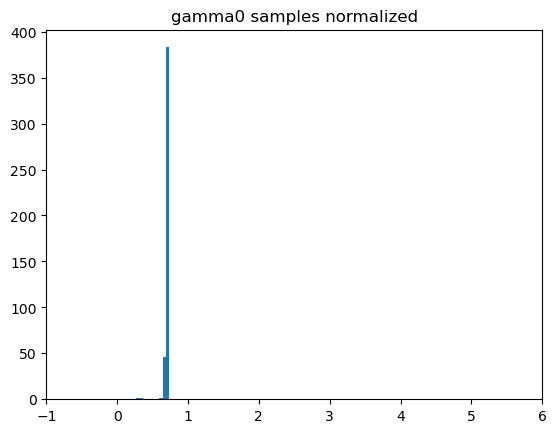

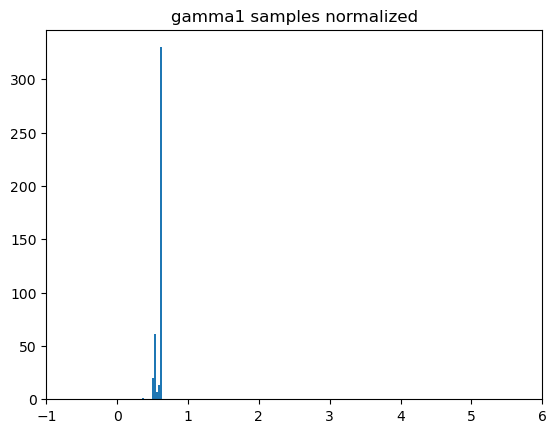

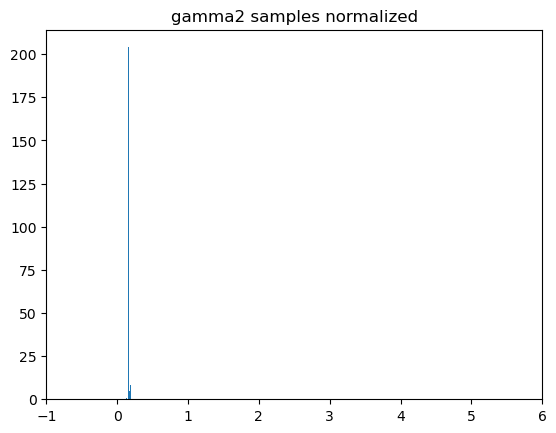

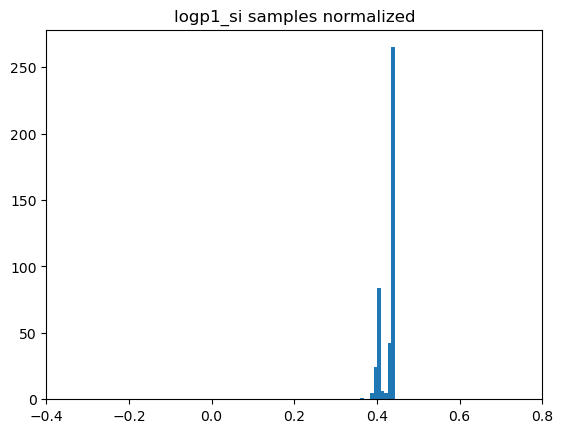

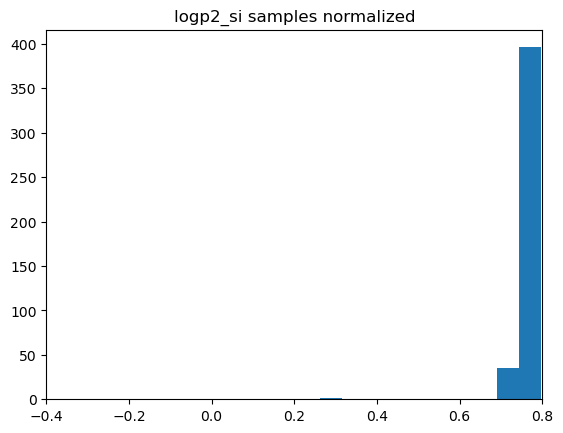

In [26]:
plt.hist(new_predictions[0])
plt.title("gamma0 samples normalized")
#print(np.min(new_predictions[0]))
#print(np.max(new_predictions[0]))
plt.xlim(-1, 6)
plt.show()

plt.hist(new_predictions[1])
plt.title("gamma1 samples normalized")
#print(np.min(new_predictions[1]))
#print(np.max(new_predictions[1]))
plt.xlim(-1, 6)
plt.show()

plt.hist(new_predictions[2])
plt.title("gamma2 samples normalized")
#print(np.min(new_predictions[2]))
#print(np.max(new_predictions[2]))
plt.xlim(-1, 6)
plt.show()

plt.hist(new_predictions[3])
plt.title("logp1_si samples normalized")
#print(np.min(new_predictions[3]))
#print(np.max(new_predictions[3]))
plt.xlim(-.4, .8)
plt.show()

plt.hist(new_predictions[4])
plt.title("logp2_si samples normalized")
#print(np.min(new_predictions[4]))
#print(np.max(new_predictions[4]))
plt.xlim(-.4, .8)
plt.show()

un-normalized outputs histogram

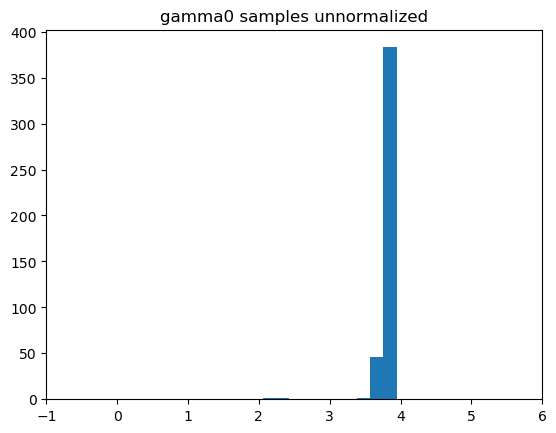

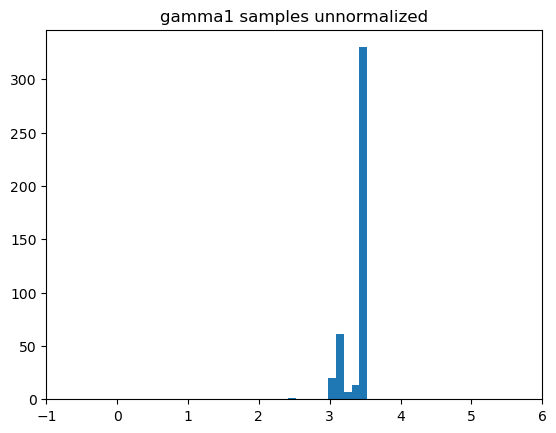

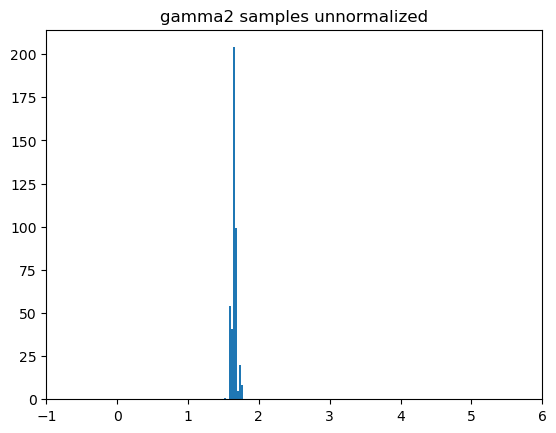

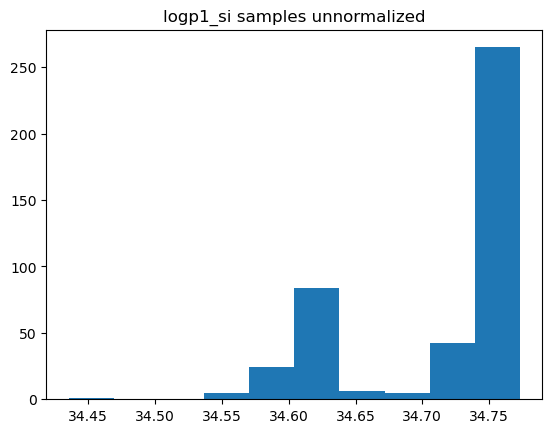

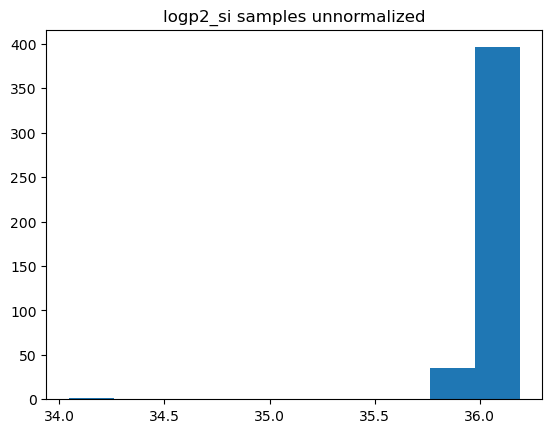

In [27]:
normgam0ar = []
for i in range (432):
    normgam0ar.append(predictions[i][0])
plt.hist(normgam0ar)
plt.title("gamma0 samples unnormalized")
plt.xlim(-1, 6)
plt.show()


normgam1ar = []
for i in range (432):
    normgam1ar.append(predictions[i][1])
plt.hist(normgam1ar)
plt.title("gamma1 samples unnormalized")
plt.xlim(-1, 6)
plt.show()


normgam2ar = []
for i in range (432):
    normgam2ar.append(predictions[i][2])
plt.hist(normgam2ar)
plt.title("gamma2 samples unnormalized")
#print(np.min(new_predictions[2]))
#print(np.max(new_predictions[2]))
plt.xlim(-1, 6)
plt.show()


normlogp1ar = []
for i in range (432):
    normlogp1ar.append(predictions[i][3])
plt.hist(normlogp1ar)
plt.title("logp1_si samples unnormalized")
#print(np.min(new_predictions[3]))
#print(np.max(new_predictions[3]))
#plt.xlim(-.4, .8)
plt.show()


normlogp2ar = []
for i in range (432):
    normlogp2ar.append(predictions[i][4])
plt.hist(normlogp2ar)
plt.title("logp2_si samples unnormalized")
#print(np.min(new_predictions[4]))
#print(np.max(new_predictions[4]))
#plt.xlim(-.4, .8)
plt.show()

# Plot one EOS

In [28]:

# log(p1) & p2 ∈ [33, 37], in cgs
# [32, 36] in si
# Γ0, Γ1, Γ2 ∈ [1.0, 5.0]

fgam0 = float(predictions[0][0])
print(fgam0)
fgam1 = float(predictions[0][1])
print(fgam1)
fgam2 = float(predictions[0][2])
print(fgam2)
flogp1 = float(predictions[0][3])
print(flogp1)
flogp2 = float(predictions[0][4]) 
print(flogp2)

3.9007158279418945
3.5227603912353516
1.623058557510376
34.77008056640625
36.17812728881836


In [29]:
oneEOS = lal.SimNeutronStarEOS3PieceDynamicPolytrope(fgam0, flogp1, fgam1, flogp2, fgam2)

In [30]:
act_hmin = 0.01
act_hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(oneEOS)

act_loghmin = np.log10(act_hmin)
act_loghmax = np.log10(act_hmax)

act_h_array = np.linspace(act_loghmin,act_loghmax,1000)

act_density = []
act_pressure = []

for h in act_h_array:
    act_density.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(10**h,oneEOS))
    act_pressure.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(10**h,oneEOS))
    
    
act_density = np.array(act_density)
act_pressure = np.array(act_pressure)

#cgs units
act_density_cgs = act_density * 1e-3
act_pressure_cgs = act_pressure * 10

act_logdensity = np.log10(act_density_cgs)
act_logpressure = np.log10(act_pressure_cgs)

Text(0, 0.5, 'pressure')

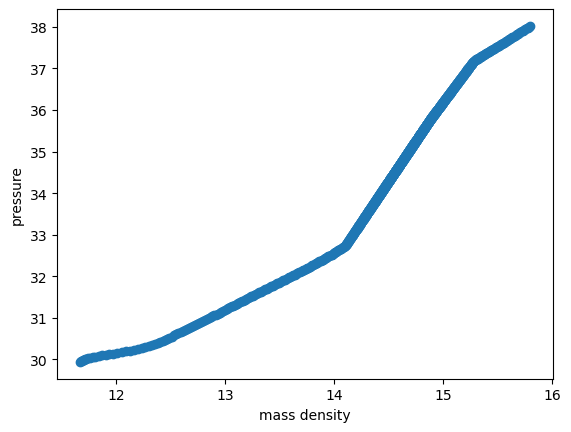

In [31]:
plt.plot(act_logdensity,act_logpressure,marker = 'o')
plt.xlabel("mass density")
plt.ylabel("pressure")
#plt.xlim([14,15.4])
#plt.ylim([32,37])

# EOS


In [32]:
#length = len(predictions)
length = 432

Progress : 0 / 432, 0.00%
Progress : 30 / 432, 6.94%
Progress : 60 / 432, 13.89%
Progress : 90 / 432, 20.83%
Progress : 120 / 432, 27.78%
Progress : 150 / 432, 34.72%
Progress : 180 / 432, 41.67%
Progress : 210 / 432, 48.61%
Progress : 240 / 432, 55.56%
Progress : 270 / 432, 62.50%
Progress : 300 / 432, 69.44%
Progress : 330 / 432, 76.39%
Progress : 360 / 432, 83.33%
Progress : 390 / 432, 90.28%
Progress : 420 / 432, 97.22%


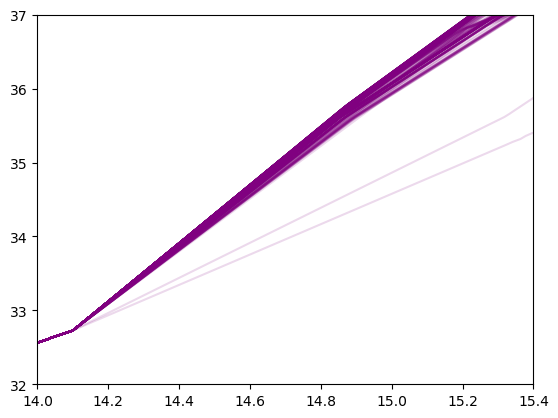

0


In [33]:
hlow_0 = 0.022460530117115313
hlow_1 = 0.024210313916473953
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
bad = 0
for i in range(length):
    try: 
        g0 = float(predictions[i][0])
        g1 = float(predictions[i][1])
        g2 = float(predictions[i][2])
        p1 = float(predictions[i][3])
        p2 = float(predictions[i][4])

        if i%30==0:
            print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
        pdat = []
        rdat = []
        #eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0[i],p1[i]-1,g1[i],p2[i]-1,g2[i])
        eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0,p1,g1,p2,g2)
        hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
        hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
        hdat = np.concatenate([hlow,hhigh])
        for h in hdat:
            pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
            rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
        #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
        plt.plot(np.log10(rdat),np.log10(pdat),color='purple',alpha=0.15)
        
    except:
        print("failed")
        bad += 1
        
plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()
print(bad)

# Actual Values EOS

In [50]:
gamma0 = np.loadtxt("eos_polytrope_gamma_0.dat.txt", dtype=float)
gamma1 = np.loadtxt("eos_polytrope_gamma_1.dat.txt", dtype=float)
gamma2 = np.loadtxt("eos_polytrope_gamma_2.dat.txt", dtype=float)
l1 = np.loadtxt('lambda_1.dat.txt', dtype=float)
l2 = np.loadtxt('lambda_2.dat.txt', dtype=float)
logp1_cgs = np.loadtxt("eos_polytrope_log_pressure_1.dat.txt", dtype=float)
logp2_cgs = np.loadtxt("eos_polytrope_log_pressure_2.dat.txt", dtype=float)
m1 = np.loadtxt("mass_1_source.dat.txt", dtype=float)
m2 = np.loadtxt("mass_2_source.dat.txt", dtype=float)

logp1_s = logp1_cgs - 1
logp2_s = logp2_cgs - 1

#length = len(gamma0)
length = 500

Progress : 0 / 500, 0.00%
Progress : 10 / 500, 2.00%
Progress : 20 / 500, 4.00%
Progress : 30 / 500, 6.00%
Progress : 40 / 500, 8.00%
Progress : 50 / 500, 10.00%
Progress : 60 / 500, 12.00%
Progress : 70 / 500, 14.00%
Progress : 80 / 500, 16.00%
Progress : 90 / 500, 18.00%
Progress : 100 / 500, 20.00%
Progress : 110 / 500, 22.00%
Progress : 120 / 500, 24.00%
Progress : 130 / 500, 26.00%
Progress : 140 / 500, 28.00%
Progress : 150 / 500, 30.00%
Progress : 160 / 500, 32.00%
Progress : 170 / 500, 34.00%
Progress : 180 / 500, 36.00%
Progress : 190 / 500, 38.00%
Progress : 200 / 500, 40.00%
Progress : 210 / 500, 42.00%
Progress : 220 / 500, 44.00%
Progress : 230 / 500, 46.00%
Progress : 240 / 500, 48.00%
Progress : 250 / 500, 50.00%
Progress : 260 / 500, 52.00%
Progress : 270 / 500, 54.00%
Progress : 280 / 500, 56.00%
Progress : 290 / 500, 58.00%
Progress : 300 / 500, 60.00%
Progress : 310 / 500, 62.00%
Progress : 320 / 500, 64.00%
Progress : 330 / 500, 66.00%
Progress : 340 / 500, 68.00%
P

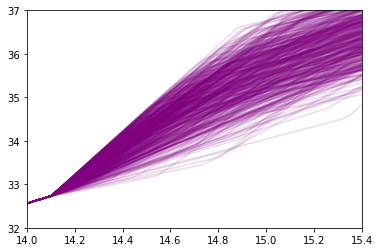

In [51]:
hlow_0 = 0.022460530117115313
hlow_1 = 0.024210313916473953
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
for i in range(length):

    g0 = float(gamma0[i])
    g1 = float(gamma1[i])
    g2 = float(gamma2[i])
    p1 = float(logp1_s[i])
    p2 = float(logp2_s[i])
    
    if i%10==0:
        print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
    pdat = []
    rdat = []
    #eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0[i],p1[i]-1,g1[i],p2[i]-1,g2[i])
    eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0,p1,g1,p2,g2)
    hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
    hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
    hdat = np.concatenate([hlow,hhigh])
    for h in hdat:
        pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
        rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
    #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
    plt.plot(np.log10(rdat),np.log10(pdat),color='purple',alpha=0.15)
plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()

# Loss

In [52]:
history.history.keys() 

dict_keys(['loss', 'gamma0_output_loss', 'gamma1_output_loss', 'gamma2_output_loss', 'logp1_si_output_loss', 'logp2_si_output_loss', 'gamma0_output_mean_squared_error', 'gamma1_output_mean_squared_error', 'gamma2_output_mean_squared_error', 'logp1_si_output_mean_squared_error', 'logp2_si_output_mean_squared_error', 'val_loss', 'val_gamma0_output_loss', 'val_gamma1_output_loss', 'val_gamma2_output_loss', 'val_logp1_si_output_loss', 'val_logp2_si_output_loss', 'val_gamma0_output_mean_squared_error', 'val_gamma1_output_mean_squared_error', 'val_gamma2_output_mean_squared_error', 'val_logp1_si_output_mean_squared_error', 'val_logp2_si_output_mean_squared_error'])

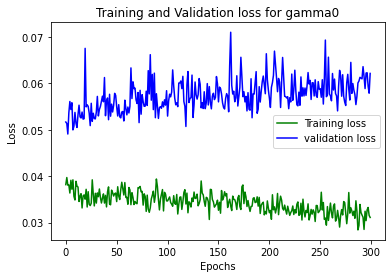

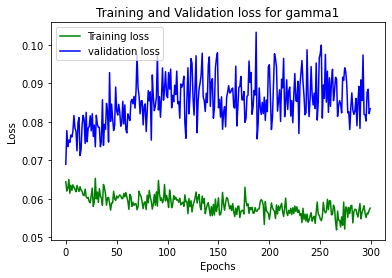

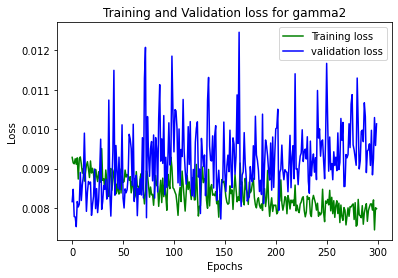

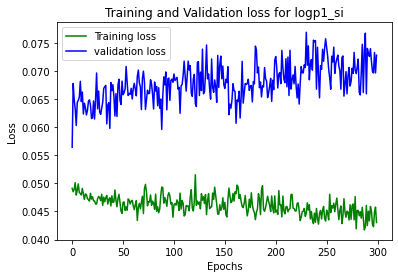

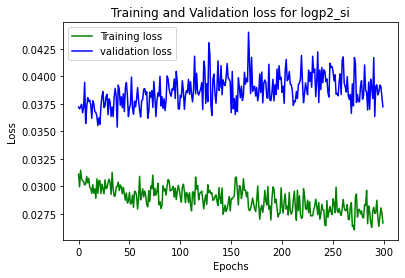

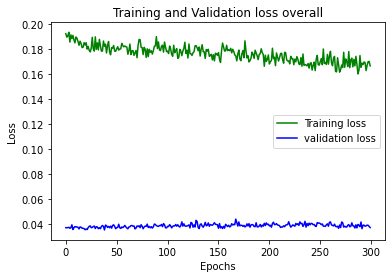

In [53]:
#loss for gamma0 values
loss_train = history.history['gamma0_output_loss']
loss_val = history.history['val_gamma0_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma1 values
loss_train = history.history['gamma1_output_loss']
loss_val = history.history['val_gamma1_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma2 values
loss_train = history.history['gamma2_output_loss']
loss_val = history.history['val_gamma2_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for logp1_si values
loss_train = history.history['logp1_si_output_loss']
loss_val = history.history['val_logp1_si_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for logp1_si')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#loss for logp2_si values
loss_train = history.history['logp2_si_output_loss']
loss_val = history.history['val_logp2_si_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for logp2_si')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#overall loss
loss_train = history.history['loss']
loss_val = history.history['val_logp2_si_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss overall')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()